# Practical 4: Working with Landsat 8 data

In this practical, we'll look at how to load and process a full Landsat 8 scene.

## Preparation 

Before attempting this practical, please download the following scene from [EarthExplorer](https://earthexplorer.usgs.gov/) (you can use another scene if you'd like, just make sure it's Collection 2 Level 2 Landsat 8):

* Path/Row: 002/062
* Acquisition date: 2016/08/24
* Landsat 8 Collection 2 Level 2 
* All bands (1-7 and 10) as well as the `something_something_MTL.txt` metadata file

Instructions for downloading data from EarthExplorer: https://www.youtube.com/watch?v=Wn_G4fvitV8

Place all `.TIF` files in the **same folder** as this notebook.

## Imports

Start by loading the required libraries.

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.exposure

## Loading data 

First thing we need to do is load some data. To do that, let's make a function that reads in the bands we want.

In [50]:
def load_scene(path, bands, crop=None):
    """
    """
    band_names = {2: "blue", 3: "green", 4: "red", 5: "nir", 6: "swir1", 7: "swir2", 10: "thermal"}
    scene = {}
    tifs_in_path = Path(path).glob("*.TIF")
    for tif_file in tifs_in_path:
        band_number = band_number_from_path(tif_file)
        band = band_names[band_number]
        if band in bands:           
            # Load the digitized image
            digitized_image = skimage.io.imread(tif_file)
            if crop is not None:
                digitized_image = digitized_image[crop[0]:crop[1], crop[2]:crop[3]]
            # Rescale the bands to surface temperature and reflectance           
            rescaled_image = rescale_digitized_band(digitized_image, band)
            # Pixels with zero uint16 values are missing values so mark them as NaN
            rescaled_image[digitized_image == 0] = np.nan
            scene[band] = rescaled_image
    return scene


def band_number_from_path(path):
    """
    """
    file_name_parts = path.stem.split("_")
    band_part_of_name = file_name_parts[-1]
    band_number = int(band_part_of_name[1:])
    return band_number
    

def rescale_digitized_band(image, band_name):
    """
    """    
    if band_name == "thermal":
        multiplicative_factor = 0.00341802
        additive_factor = 149.0 - 273
    else:
        multiplicative_factor = 2.75e-05
        additive_factor = -0.2            
    rescaled_image = image * multiplicative_factor + additive_factor
    return rescaled_image

In [3]:
scene_full = load_scene(
    "momotombo/LC08_L2SP_017051_20151103_20200908_02_T1/", 
    bands=("blue", "green", "red"),
)

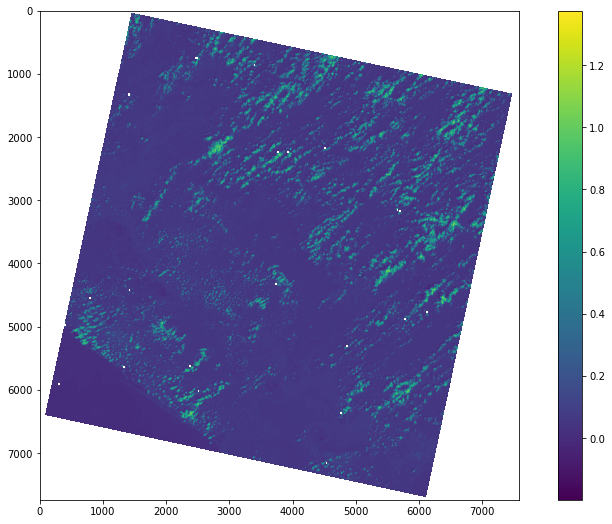

In [4]:
plt.figure(figsize=(14, 9))
plt.imshow(scene_full["green"])
plt.colorbar()

In [5]:
def make_composite(scene, red, green, blue, in_range):
    """
    """
    nrows, ncols = scene[red].shape
    composite = np.empty((nrows, ncols, 3), dtype="uint8")
    bands = [red, green, blue]
    for i, band in enumerate(bands):
        composite[:, :, i] = skimage.exposure.rescale_intensity(
            scene[band],
            in_range=in_range,
            out_range="uint8",
        )
    return composite

In [6]:
scene_full["rgb"] = make_composite(scene_full, red="red", green="green", blue="blue", in_range=(0, 0.15))

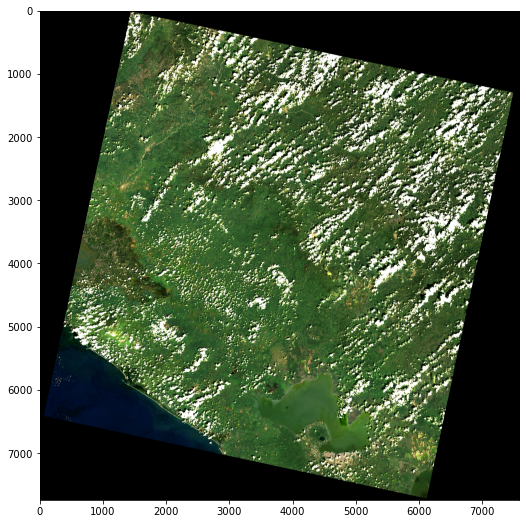

In [7]:
plt.figure(figsize=(14, 9))
plt.imshow(scene_full["rgb"])

In [51]:
scene = load_scene(
    "momotombo/LC08_L2SP_017051_20151205_20200908_02_T1/", 
    bands=["blue", "green", "red", "nir", "swir1", "swir2", "thermal"],
    crop=[5850, 6100, 3500, 3800],
)

In [52]:
scene["rgb"] = make_composite(scene, red="red", green="green", blue="blue", in_range=(0, 0.15))

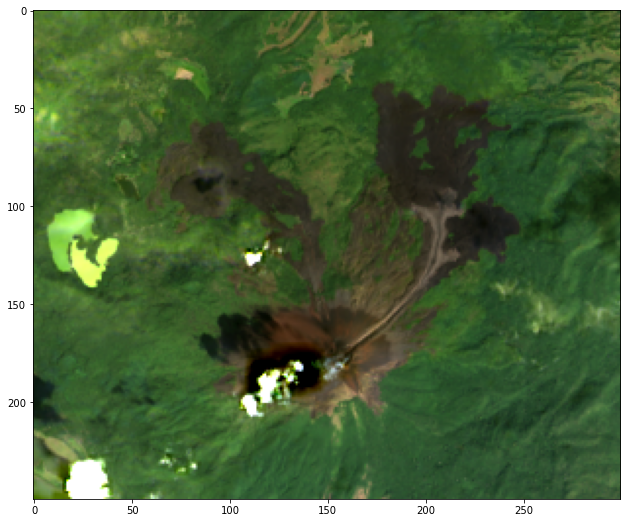

In [53]:
plt.figure(figsize=(14, 9))
plt.imshow(scene["rgb"])

In [54]:
scene["cir"] = make_composite(scene, red="nir", green="red", blue="green", in_range=(0, 0.6))

In [101]:
scene["cir"] = make_composite(scene, red="swir2", green="swir1", blue="red", in_range=(0, 0.5))

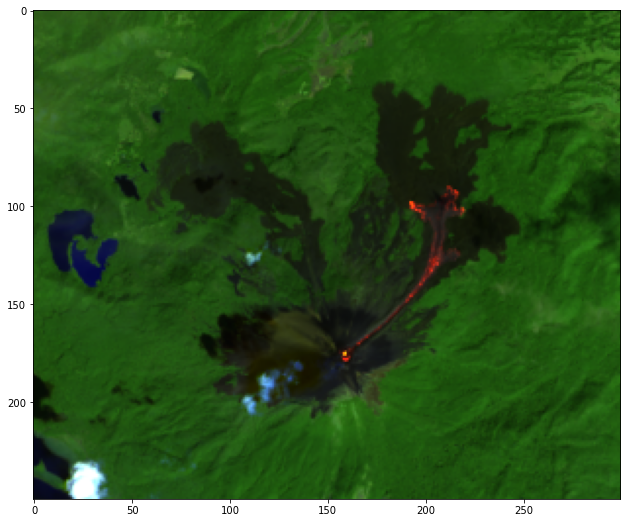

In [102]:
plt.figure(figsize=(14, 9))
plt.imshow(scene["cir"])

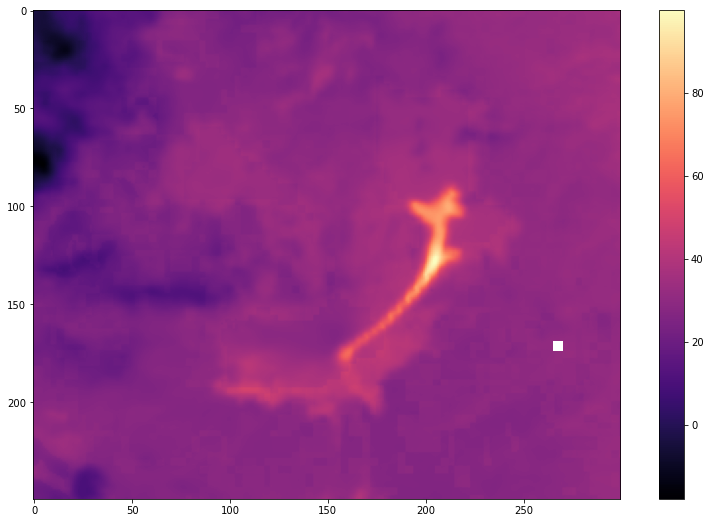

In [92]:
plt.figure(figsize=(14, 9))
plt.imshow(scene["thermal"], cmap="magma")
plt.colorbar()

In [60]:
def make_ndvi(scene):
    result = (scene["nir"] - scene["red"]) / (scene["nir"] + scene["red"])
    return result

In [61]:
scene["ndvi"] = make_ndvi(scene)

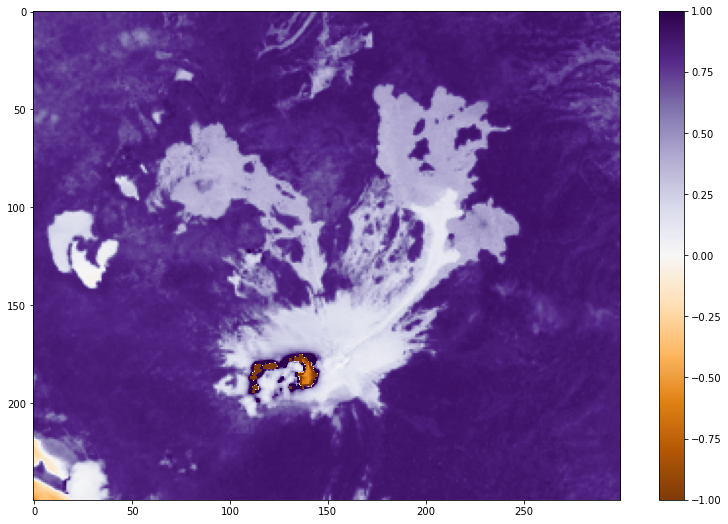

In [62]:
plt.figure(figsize=(14, 9))
plt.imshow(scene["ndvi"], vmin=-1, vmax=1, cmap="PuOr")
plt.colorbar()